<a href="https://colab.research.google.com/github/AlexeyK12/Data_scientist-Sberuniversity/blob/main/representation_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача обучения нейронных сетей как задача обучения представления. Использование готовых представлений: transfer learning

В данном ноутбуке будем обучать модели на данных из скважин. Несмотря на то, что мы будем работать с синтетическими данными, они отражают зависимости, присутствующие в реальных данных, получаемых при бурении скважин.

Целью наших экспериментов является сравнение качества представлений скважин разных моделей. Сначала мы обучим $4$ модели:
* Триплет-модель
* Сиамскую модель
* BYOL
* Авторегрессионную модель

Затем сравним качество представлений, полученных с их помощью. Подробнее про алгоритм действия для обучения моделей и сравнение качества представлений можно почитать в соответствующих разделах.

На рисунке схематично представлен процесс передачи данных бурения скважин в нейронную сеть, которая получает представления скважин в некотором пространстве представлений, где их можно сравнивать между собой.



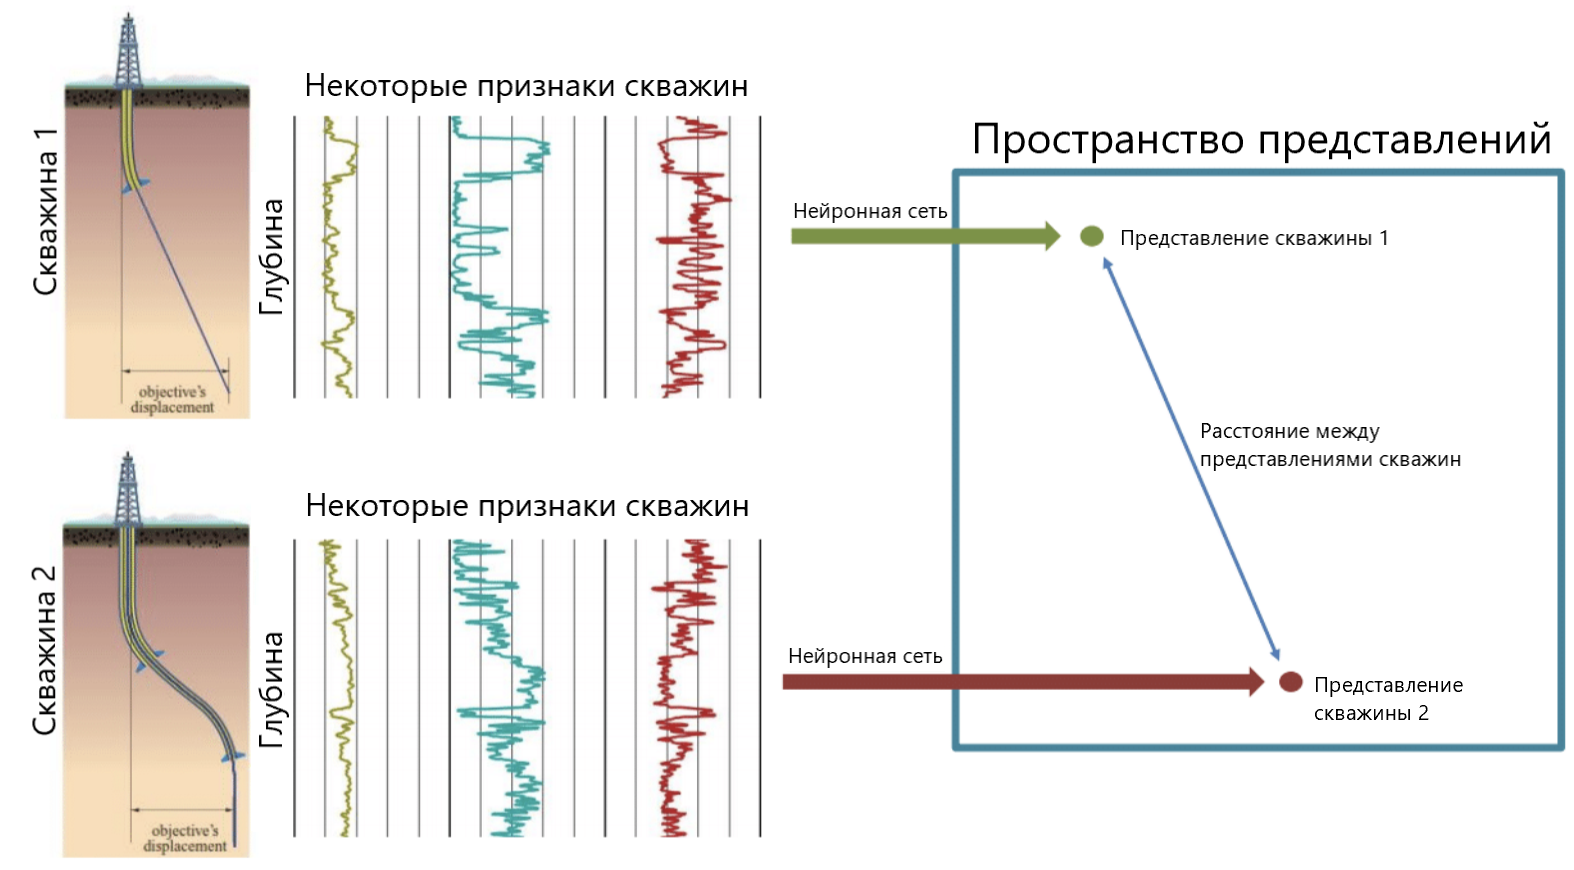

# Импорт библиотек

Сначала импортируем все необходимые библиотеки. Поскольку некоторые из необходимых библиотек, скорее всего, не были установлены ранее, установим их, раскомментировав $4$ ячейки ниже.

In [ ]:
# !pip install pytorch_lightning

In [ ]:
# !pip install 'git+https://github.com/PyTorchLightning/lightning-flash.git'
# # или !pip install lightning-flash

In [ ]:
# !pip install --ignore-installed PyYAML

In [ ]:
# !pip install lightly

In [ ]:
from copy import deepcopy

import numpy as np
import pandas as pd
import pytorch_lightning as pl
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from flash.core.optimizers import LARS
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules import BYOLProjectionHead, BYOLPredictionHead
from lightly.models.utils import (
    deactivate_requires_grad,
    update_momentum
)
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    roc_auc_score,
)
from sklearn.preprocessing import StandardScaler
from torch.utils.data import (
    DataLoader,
    Dataset
)
from tqdm import tqdm
from xgboost import XGBClassifier

Для воспроизводимости результатов зафиксируем всевозможные состояния в различных библиотеках. Мы также будем учитывать, что вычисления могут производиться как на ЦПУ (CPU), так и на графическом процессоре (GPU).  

In [ ]:
def fix_seeds(seed_value=42, device="cpu"):
    """Функция для воспроизводимости наших результатов. Источник: `https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/5`.

    :param seed_value: состояние
    :param device: девайс, состояние которого мы хотим зафиксировать
    """
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != "cpu":
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [ ]:
GPU = [0] # наши ресурсы позволяют нам выбрать одну из нескольких видеокарт, мы выбираем ту, у которой индекс 0
# если запускать обучение на процессоре, то нужно установить `GPU = 0`

# Для выбранного устройства, на котором будут производиться вычисления,
# зафиксируем состояния для воспроизводимости результатов

fix_seeds(seed_value=42, device="cuda:0")

# Чтение и предобработка данных

В данном примере будем работать с синтетическими данными, которые некоторым образом отражают четыре из основных характеристик скважин. Рассматриваемые признаки встречаются при логировании бурения скважины. В нашем датасете представлены четыре синтетические скважины. Мы также предполагаем, что данные отсортированы таким образом, что для каждой скважины выполняется следующее правило: при увеличении индекса строки в таблице данных увеличивается и глубина, на которой были измерены значения указанных признаков.

Если вы работаете в Google Colab, можно нажать знак папки слева и переместить туда файл с данными, чтобы можно было с ними работать.

In [ ]:
df = pd.read_csv("synthetic_well_log_data.csv")
df

,DRHO,DENS,GR,DTC,WELLNAME
0,0.01778,2.3794,1.214982,101.5516,0
1,0.01701,2.3705,1.086457,101.6722,0
2,0.01624,2.3615,0.957933,101.7928,0
3,0.01779,2.3593,0.493992,101.1051,0
4,0.02008,2.3591,-0.076734,100.1601,0
...,...,...,...,...,...
730,0.11269,2.6161,0.742381,92.0410,3
731,0.11269,2.6161,0.775581,92.1752,3
732,0.11269,2.6161,0.686798,91.6055,3
733,0.11269,2.6161,0.614402,91.7522,3


Видно, что данных не так много. Посмотрим на названия скважин.

In [ ]:
df["WELLNAME"].unique()

array([0, 1, 2, 3])

Поскольку название скважины — число (причем от 0 до 3), никак изменять данную колонку не будем.

## Деление выборки на обучающую и тестовую

Скважины будем рассматривать как временные ряды, только в качестве «времени» будет выступать глубина. Так как скважины — временные ряды, то обучающую и тестовую выборки будут составлять два отдельных не пересекающихся множества скважин, т. е. две скважины отправим в обучающую выборку, другие две — в тестовую.  

In [ ]:
train_wells = [2, 3] # номера скважин обучающей выборки
test_wells = [0, 1] # номера скважин тестовой выборки

train_data = df[df["WELLNAME"].isin(train_wells)]
test_data = df[df["WELLNAME"].isin(test_wells)]

train_data.shape, test_data.shape, train_data["WELLNAME"].unique(), test_data["WELLNAME"].unique()

((447, 5), (288, 5), array([2, 3]), array([0, 1]))

Все признаки у нас числовые, мы будем использовать нейронные сети, поэтому нормализуем данные.

In [ ]:
scaler = StandardScaler()

columns = deepcopy(train_data.columns.tolist())
columns.remove("WELLNAME") # в columns будут находиться названия признаков, которые нужно нормализовать
# будем нормализовывать все признаки, кроме WELLNAME, который содержит название скважины

train_data_sc = pd.DataFrame(
    scaler.fit_transform(
        train_data.drop("WELLNAME", axis=1).values
    ),
    columns=columns
)
test_data_sc = pd.DataFrame(
    scaler.transform(
        test_data.drop("WELLNAME", axis=1).values
    ),
    columns=columns
)

train_data_sc["WELLNAME"] = train_data["WELLNAME"].values
test_data_sc["WELLNAME"] = test_data["WELLNAME"].values

train_data_sc.shape, test_data_sc.shape, train_data_sc["WELLNAME"].unique(), test_data_sc["WELLNAME"].unique()

((447, 5), (288, 5), array([2, 3]), array([0, 1]))

`train_data_sc` и `test_data_sc` представляют собой таблицы `pd.DataFrame` обучающей и тестовой выборок, но с нормализованными признаками.

## Формирование датасета

Обучать и тестировать модели будем с помощью фреймвока [pytorch](https://pytorch.org/). Для работы с какими-либо данными в `pytorch` необходимо сначала создать специальный датасет, из которого будет сформирован даталоадер, позволяющий при обучении модели работать не с одним экземпляром выборки, а с несколькими. Если используется какой-то стандартный датасет, например [MNIST](https://nextjournal.com/gkoehler/pytorch-mnist) или [CIFAR](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html), то достаточно просто загрузить датасет из библиотеки с помощью нескольких строк кода. Наши данные необычные, поэтому мы напишем свой класс, который будет генерировать нужный нам датасет.

In [ ]:
print("Длина каждой скважины\n")
for well_name, well_data in df.groupby("WELLNAME"):
    print(
        "Скважина {}: длина = {}".format(well_name, len(well_data))
    )

Длина каждой скважины

Скважина 0: длина = 165
Скважина 1: длина = 123
Скважина 2: длина = 232
Скважина 3: длина = 215


Все наши скважины имеют разную длину. Кроме того, даже если бы их длина была одинаковой, данных у нас в целом мало. Но мы можем сгенерировать достаточное количество интервалов меньшей длины. Мы будем работать с последовательными интервалами длины 100. В ячейке ниже находится функция, генерирующая необходимое количество (обозначим его $N$) интервалов нужной длины. Сперва случайным образом выбираются $N$ произвольных точек — начала наших интервалов, затем получается список из интервалов.

In [ ]:
def generate_random_samples(
    random_seed,
    df,
    interval_len,
    results_len,
):
    """Генерирует последовательные интервалы определенной длины.
    :param random_seed: для воспроизводимости результатов
    :param df: исходные данные
    :param interval_len: длина одного интервала
    :param results_len: количество интервалов, которые необходимо сгенерировать (N в описании в ячейке выше)
    :return: список интервалов
    """
    np.random.seed(random_seed)

    random_inds = np.round(
        np.random.uniform(0, len(df) - interval_len, results_len)
    ).astype(int)
    random_sample = [df.iloc[i : i + interval_len] for i in random_inds]
    return random_sample

Чтобы использовать одинаковую выборку для всех наших моделей, напишем функцию, которая будет генерировать триплеты интервалов. Каждый триплет будет состоять из следующих элементов:
1. «Якорный» интервал (anchor). Случайный интервал из какой-то скважины
2. «Положительный» интервал (positive). Случайный интервал из той же скважины, что и anchor
3. «Отрицательный» интервал (negative). Случайный интервал из скважины, отличной от скважины anchor

In [ ]:
def generate_triplet_intervals(df, interval_len, results_len):
    anchors, positives, negatives = [], [], []
    for well in df["WELLNAME"].unique():
        anchors.extend(
            generate_random_samples(
                123,
                df[df["WELLNAME"] == well],
                interval_len,
                results_len // df["WELLNAME"].nunique()
            )
        )
        positives.extend(
            generate_random_samples(
                124, # выбираем другой `random_seed`, чтобы получились интервалы, отличные от anchor
                df[df["WELLNAME"] == well],
                interval_len,
                results_len // df["WELLNAME"].nunique()
            )
        )
        negatives.extend(
            generate_random_samples(
                123,
                df[df["WELLNAME"] != well],
                interval_len,
                results_len // df["WELLNAME"].nunique()
            )
        )
    return anchors, positives, negatives

Напишем свой класс датасета, элементом которого будет являться кортеж, состоящий из:
- Anchor
- Positive
- Negative
- Номера скважины anchor (и positive)
- Номера скважины negative

In [ ]:
class TripletDatasetIntervals(Dataset):
    def __init__(
        self,
        df,
        interval_len,
        results_len,
    ):
        self.interval_len = interval_len

        self.anchors, self.positives, self.negatives = generate_triplet_intervals(
            df, interval_len, results_len,
        )

    def __len__(self) -> int:
        return len(self.anchors)

    def __getitem__(self, idx):
        anchor = self.anchors[idx]
        positive = self.positives[idx]
        negative = self.negatives[idx]

        return (
            anchor.drop("WELLNAME", axis=1).values.astype(np.float32),
            positive.drop("WELLNAME", axis=1).values.astype(np.float32),
            negative.drop("WELLNAME", axis=1).values.astype(np.float32),
            anchor["WELLNAME"].iloc[0],
            negative["WELLNAME"].iloc[0],
        )

In [ ]:
INTERVAL_LEN = 100     # длина одного интервала
TRAIN_DATA_LEN = 10000 # кол-во кортежей из триплетов и номеров скважин в обучающей выборке
VAL_DATA_LEN = 5000    # кол-во кортежей из триплетов и номеров скважин в валидационной выборке

Генерация датасетов.

In [ ]:
train_intervals_dataset = TripletDatasetIntervals(
    train_data_sc,
    interval_len=INTERVAL_LEN,
    results_len=TRAIN_DATA_LEN,
)
val_intervals_dataset = TripletDatasetIntervals(
    test_data_sc,
    interval_len=INTERVAL_LEN,
    results_len=VAL_DATA_LEN,
)

Посмотрим на элемент из обучающей выборки. Это можно сделать и с помощью цикла, например:
```
for el in train_intervals_dataset:
    print(el)
    break
```
А можно и так, как показано в ячейке ниже:

In [ ]:
el_train = next(iter(train_intervals_dataset)) # таким образом выбирается один случайный элемент датасета

len(el_train), el_train[0].shape, el_train[1].shape, el_train[2].shape, el_train[3], el_train[4]

(5, (100, 4), (100, 4), (100, 4), 2, 3)

Аналогичным образом посмотрим на элемент из валидационной выборки:

In [ ]:
el_val = next(iter(val_intervals_dataset))

len(el_val), el_val[0].shape, el_val[1].shape, el_val[2].shape, el_val[3], el_val[4]

(5, (100, 4), (100, 4), (100, 4), 0, 1)

# Обучение моделей

В целом наша задача состоит в том, чтобы выучить представления интервалов скважин таким образом, чтобы с ними можно было работать в дальнейшем. Мы обучим несколько моделей: триплет-модель, сиамскую модель, BYOL и авторегрессионную модель, затем сгенерируем новые обучающую и тестовую выборки, получим для них представления интервалов с помощью наших обученных моделей, а затем обучим модель градиентного бустинга определять, к какой скважине принадлежит тот или иной интервал. Чем лучше представления, тем выше будут метрики классификации градиентного бустинга.

В качестве базовой модели почти для всех архитектур будем использовать [LSTM](https://habr.com/ru/company/wunderfund/blog/331310/) из ячейки ниже.

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_rnn_size):
        super(RNNModel, self).__init__()

        self.hidden_rnn_size = hidden_rnn_size
        self.rnn = nn.LSTM(input_size, self.hidden_rnn_size, batch_first=True)

    def forward(self, input_interval):
        output, (h_n, c_n) = self.rnn(input_interval)
        return output, (h_n, c_n)

Мы решили использовать [pytorch](https://pytorch.org/) для обучения нейросетей, однако, в отличие от, например, [tensorflow](https://www.tensorflow.org/) и [keras](https://keras.io/), в `pytorch` необходимо в явном виде прописывать цикл обучения. В общем виде он выглядит следующим образом:

```
for epoch in range(EPOCHS):
    train_epoch_loss = 0
    train_epoch_metrics = 0
    for batch_idx, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()

        y_pred = model(data)
        loss = loss_function(y_pred, target.long())

        metrics = calc_metrics(y_pred, target)

        train_epoch_loss += loss.item()
        train_epoch_metrics += metrics.data.item()

        loss.backward()
        optimizer.step()

    print(
        "Epoch {}: train loss={}, train metrics={}".format(
            epoch+1,
            train_epoch_loss/(batch_idx+1),
            train_epoch_acc/(batch_idx+1),
        )
    )
```

Тестирование модели в общем виде выглядит следующим образом:
```
predictions = []
targets = []
val_loss = 0

with torch.no_grad():
    model.eval()
    for data, target in test_loader:
        prediction = model(data)
        loss = loss_function(prediction, target.long())

        val_loss += np.array(loss)

        predictions += np.array(prediction).tolist()
        targets += target.long().detach().numpy().tolist()

metrics = calc_metrics(targets, predictions)
```

Для упрощения задачи будем использовать специальную обертку [pytorch_lightning](https://www.pytorchlightning.ai/), которая упростит процесс написания кода.

## Триплет-модель


Данной модели необходимы три интервала: `anchor`, `positive` и `negative`. Функция потерь триплет-модели устроена таким образом, что после обучения модели похожие объекты (а именно `anchor` и `positive`) в пространстве представлений находятся близко друг к другу, а непохожие (`anchor` и `negative`) — далеко. Выходом модели при таком подходе будет векторное представление исходного временного ряда (в нашем случае интервала скважины). Если, например, по паре интервалов мы хотим понять, относятся ли они к одной скважине, можно использовать евклидово (или косинусное) расстояние между векторными представлениями пары интервалов либо же обучить небольшую полносвязную сеть (или другой классификатор).

In [ ]:
class AbstractModel(pl.LightningModule):
    def __init__(
        self,
        train_data,
        test_data,
        learning_rate,
        batch_size,
    ):
        """Инициализация абстрактного класса (нужен для фиксирования вещей, которые будут повторяться для всех моделей).

        :param train_data: обучающая выборка -- сформированный датасет с триплетами
        :param test_data: тестовая выборка -- сформированный датасет с триплетами
        :param learning_rate: параметр, отвечающий за размер шага optimizer
        :param batch_size: размер батча
        """
        super(AbstractModel, self).__init__()

        self.train_data = train_data
        self.val_data = test_data

        self.learning_rate = learning_rate
        self.batch_size = batch_size

    def train_dataloader(self):
        """Формирование даталоадера для обучающей выборки.

        :return: даталоадер из обучающей выборки
        """
        train_dataloader = DataLoader(
            self.train_data, batch_size=self.batch_size, shuffle=True, num_workers=0
        )
        return train_dataloader

    def val_dataloader(self):
        """Формирование даталоадера для валидационной выборки.

        :return: даталоадер из валидационной выборки
        """
        val_dataloader = DataLoader(
            self.val_data, batch_size=self.batch_size, shuffle=False, num_workers=0
        )
        return val_dataloader

In [ ]:
class TripletModel(AbstractModel):
    def __init__(
        self,
        model,
        train_data,
        test_data,
        learning_rate,
        batch_size,
    ):
        """Инициализация класса триплет-модели.

        :param model: базовая модель
        :param train_data: обучающая выборка -- сформированный датасет с триплетами
        :param test_data: тестовая выборка -- сформированный датасет с триплетами
        :param learning_rate: параметр, отвечающий за размер шага optimizer
        :param batch_size: размер батча
        """
        super().__init__(train_data, test_data, learning_rate, batch_size)
        self.model = model
        self.loss_function = nn.TripletMarginLoss(margin=1.75)

    def forward(self, inputs):
        """Получение выхода модели.

        :param inputs: интервал из скважины
        :return: векторное представление интервала -- поскольку в нашем случае в качестве базовой модели используется LSTM,
                 векторное представление входного интервала -- последнее скрытое состояние
        """
        return torch.squeeze(self.model(inputs)[1][0])

    def _step(self, batch):
        """Шаг модели. Одинаков и для обучения, и для валидации.

        :param batch: батч, каждый элемент которого -- кортеж из 5-ти элементов:
                      - anchor
                      - positive
                      - negative
                      - номер скважины anchor
                      - номер скважины negative
        :return: словарь, состоящий из функции потерь
        """
        anchor, positive, negative, well_anchor_positive, well_negative = batch

        anchor_out = self.forward(anchor)
        positive_out = self.forward(positive)
        negative_out = self.forward(negative)

        loss = self.loss_function(anchor_out, positive_out, negative_out)

        logs = {"loss": loss}

        return logs

    def training_step(self, batch, batch_idx):
        """Шаг обучения модели.

        :param batch: батч
        :param batch_idx: индекс батча (необходим для `pytorch_lightning`)
        :return: значение функции потерь на обучающей выборке
        """
        logs = self._step(batch)
        self.log_dict(
            {f"train_{k}": v for k, v in logs.items()},
            on_step=False, on_epoch=True, prog_bar=True
        )
        return logs

    def validation_step(self, batch, batch_idx):
        """Шаг валидации модели.

        :param batch: батч
        :param batch_idx: индекс батча
        :return: значение функции потерь на валидационной выборке
        """
        logs = self._step(batch)
        self.log_dict(
            {f"val_{k}": v for k, v in logs.items()},
            prog_bar=True
        )
        return logs

    def configure_optimizers(self):
        """Инициализация оптимизатора.

        :return: оптимизатор Adam с `learning_rate`, заданным при инициализации класса
        """
        opt = torch.optim.Adam(
            self.model.parameters(), lr=self.learning_rate
        )
        return opt

In [ ]:
# Инициализация базовой модели

triplet_rnn = RNNModel(
    input_size=4,
    hidden_rnn_size=64,
)

Каким лучше выбрать размер батча и количество эпох обучения?

`BATCH_SIZE`: существует мнение, что лучше брать значения, кратные 2. Это связано с тем, что в низкоуровневом представлении задействована непосредственно двоичная система исчисления. С одной стороны, размер батча должен быть небольшим, чтобы оптимизатор каждый раз находил минимум функции потерь «по-разному», но он не должен быть совсем мал, чтобы процесс обучения не затягивался. Самыми оптимальными вариантами являются `BATCH_SIZE = 64` и `BATCH_SIZE = 128`. Можно брать и другие размеры батча, даже не кратные 2, но в таком случае обучение может занимать больше времени, чем при большем батче, но кратном 2.

`EPOCHS`: количество эпох надо брать таким, чтобы модель успела обучиться, но не начала переобучаться. Помочь с этим могут, например:
* **Визуализация процесса обучения**. Если визуализировать графики функции потерь при обучении и валидации, то они должны уменьшаться и выходить на плато. Если при обучении функция потерь уменьшается и выходит на плато, а при валидации — увеличивается, то модель переобучается. Если ни в процессе обучения, ни в процессе валидации функция потерь не выходит на плато, но уменьшается, значит, что модель недообучается
* **Early Stopping**. После каждой эпохи сравниваются значения функции потерь на обучающей выборке на текущем и предыдущем шаге. Если значение функции потерь на текущем шаге больше, чем на предыдущем, счетчик увеличивается на $1$. Если на следующей эпохе это повторяется, то счетчик увеличивается, иначе обнуляется. Если значение счетчика стало равно определенному значению (за которое чаще всего отвечает параметр `patience`), то процесс обучения модели останавливается. Обычно берут `patience` в районе 7. Мы не будем использовать данный метод в нашем решении, поскольку гиперпараметры моделей и количество эпох подобраны таким образом, что происходят нужные нам действия, но на практике данный подход часто применяется

In [ ]:
BATCH_SIZE = 64
EPOCHS = 20

In [ ]:
def train_model(experiment_name, log_dir, model, epochs, gpu):
    """Обучение модели.

    :param experiment_name: название эксперимента для удобства логирования экспериментов
    :param log_dir: папка, куда будут сохранятся логи
    :param model: модель, которая будет обучаться (полная архитектура, например, триплет или сиамская сеть, не базовая модель)
    :param epochs: количество эпох обучения
    :param gpu: номер видеокарты либо 0, если обучение происходит на процессоре
    :return: обученная модель
    """
    logger = pl.loggers.TensorBoardLogger(save_dir=log_dir, name=experiment_name)

    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        monitor="val_loss",
        dirpath=f"{log_dir}/{experiment_name}",
        filename="{epoch:02d}-{val_loss:.3f}",
        mode="min",
    )

    trainer = pl.Trainer(
        max_epochs=epochs,
        gpus=gpu,
        benchmark=True,
        check_val_every_n_epoch=1,
        logger=logger,
        callbacks=[checkpoint_callback],
    )

    trainer.fit(model)

    return model

Инициализация и обучение триплет-модели.

In [ ]:
PATH_TO_LOGS = "./logs" # путь до директории, где будут храниться логи

In [ ]:
interval_model_triplet = TripletModel(
    model=triplet_rnn,
    train_data=train_intervals_dataset,
    test_data=val_intervals_dataset,
    learning_rate=1e-4,
    batch_size=BATCH_SIZE,
)

interval_model_triplet = train_model(
    experiment_name="triplet_rnn",
    log_dir=PATH_TO_LOGS,
    model=interval_model_triplet,
    epochs=EPOCHS,
    gpu=GPU,
)

## Сиамская модель

Представляет собой несколько (как правило, 2) «голов» — одинаковые модели, выдающие некоторые представления входных данных, и часть, которая объединяет представления, полученные с «голов», и прогоняет через последующие слои, на выходе из которых получается либо число (в случае задачи регрессии), либо вектор вероятностей принадлежности к классам (в задаче классификации). В нашем случае в качестве «голов» будем использовать определенную нами ранее `RNNModel`. Мы будем действовать следующим образом: пусть на вход наша модель принимает два интервала, и нам известно, принадлежат они одной скважине или нет. Мы будем прогонять каждый интервал через `RNNModel`, брать последнее скрытое состояние, объединять их и подавать на вход полносвязной сети.

Подробное описание сиамской и триплет-модели на аналогичных данных приведено [в статье](https://arxiv.org/pdf/2202.05583.pdf).

In [ ]:
class RNNModelSiamese(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        hidden_rnn_size,
        dropout_prob,
    ):
        """Инициализация базовой модели для реализации сиамской сети.

        :param input_size: размер входных данных
        :param output_size: размер выходных данных
        :param hidden_rnn_size: размерность скрытого слоя реккурентной части
        :param dropout_prob: значение Dropout для полносвязной части
        """
        super(RNNModelSiamese, self).__init__()

        self.rnn = RNNModel(input_size, hidden_rnn_size)
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_rnn_size, 4 * hidden_rnn_size),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(4 * hidden_rnn_size, 2 * hidden_rnn_size),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(2 * hidden_rnn_size, output_size),
            nn.Sigmoid(),
        )

    def forward(self, input_intervals):
        """Получение выхода модели.

        :param input_intervals: пара интервалов
        :return: вероятность того, что интервалы принадлежат одной скважине
        """
        interval_1, interval_2 = input_intervals

        output_1, (h_n_1, c_n_1) = self.rnn(interval_1)
        output_2, (h_n_2, c_n_2) = self.rnn(interval_2)

        # Соединяем скрытые состояния и передаем их в полносвязную часть
        output = torch.squeeze(torch.cat([h_n_1, h_n_2], dim=2))

        return self.fc(output)

In [ ]:
class SiameseModel(AbstractModel):
    def __init__(
        self,
        model,
        train_data,
        test_data,
        learning_rate,
        batch_size,
    ):
        """Инициализация сиамской модели.

        :param model: базовая модель
        :param train_data: обучающая выборка -- сформированный датасет с триплетами
        :param test_data: тестовая выборка -- сформированный датасет с триплетами
        :param learning_rate: параметр, отвечающий за размер шага optimizer
        :param batch_size: размер батча
        """
        super().__init__(train_data, test_data, learning_rate, batch_size)
        self.model = model
        self.loss_function = nn.BCELoss()

    def forward(self, inputs):
        """Получение выхода модели.

        :param inputs: пара интервалов
        :return: вероятность того, что интервалы принадлежат одной скважине
        """
        return self.model(inputs)

    def _step(self, batch):
        """Шаг модели. Одинаков и для обучения, и для валидации.

        :param batch: батч, каждый элемент которого -- кортеж из 5-ти элементов:
                      - anchor
                      - positive
                      - negative
                      - номер скважины anchor
                      - номер скважины negative
        :return: словарь
                 - значение функции потерь
                 - PR AUC
                 - значения целевой переменной (1 если интервалы из одной скважины и 0 -- если из разных)
                 - предсказания модели (вероятности принадлежности к классу 1
        """
        anchor, positive, negative, well_anchor_positive, well_negative = batch

        target_1_pred = self.forward([anchor, positive])
        target_0_pred = self.forward([anchor, negative])

        predictions = torch.cat((target_1_pred.squeeze(), target_0_pred.squeeze()))
        all_targets = torch.cat(
            (
                torch.ones(anchor.shape[0]).float(),
                torch.zeros(anchor.shape[0]).float(),
            )
        ).to(predictions.device)
        loss = self.loss_function(predictions, all_targets)
        pr_auc = average_precision_score(
            all_targets.detach().cpu().numpy().squeeze(),
            predictions.detach().cpu().numpy().squeeze(),
        )
        logs = {
            "loss": loss,
            "pr_auc": pr_auc,
            "target": all_targets,
            "predictions": predictions,
        }
        return logs

    def training_step(self, batch, batch_idx):
        """Шаг обучения модели.

        :param batch: батч
        :param batch_idx: индекс батча
        :return: словарь из self._step
        """
        logs = self._step(batch)
        self.log("train_loss", logs["loss"],
                 on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_pr_auc", logs["pr_auc"],
                 on_step=False, on_epoch=True, prog_bar=True)
        return logs

    def validation_step(self, batch, batch_idx):
        """Шаг валидации модели.

        :param batch: батч
        :param batch_idx: индекс батча
        :return: словарь из self._step
        """
        logs = self._step(batch)
        self.log("val_loss", logs["loss"], prog_bar=True)
        self.log("val_pr_auc", logs["pr_auc"], prog_bar=True)
        return logs

    def validation_epoch_end(self, outputs):
        """Логирование среднего значения PR AUC после валидации.

        :param outputs: словарь, который получается в результате метода `validation_step`
        """
        predictions = torch.cat([x["predictions"] for x in outputs])
        target = torch.cat([x["target"] for x in outputs])

        pr_auc = average_precision_score(
            target.detach().cpu().numpy().squeeze(),
            predictions.detach().cpu().numpy().squeeze(),
        )
        print("mean_pr_auc", pr_auc)
        self.log("mean_pr_auc", pr_auc, prog_bar=True)

    def configure_optimizers(self):
        """Инициализация оптимизатора.

        :return: оптимизатор Adam с `learning_rate`, заданным при инициализации класса
        """
        opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return opt

In [ ]:
# Инициализация базовой модели для сиамской сети

siamese_rnn = RNNModelSiamese(
    input_size=4,
    output_size=1,
    hidden_rnn_size=16,
    dropout_prob=0.25,
)

Обучение и тестирование сиамской модели.

In [ ]:
interval_model_siamese = SiameseModel(
    model=siamese_rnn,
    train_data=train_intervals_dataset,
    test_data=val_intervals_dataset,
    learning_rate=1e-3,
    batch_size=BATCH_SIZE,
)

interval_model_siamese = train_model(
    experiment_name="siamese_rnn",
    log_dir=PATH_TO_LOGS,
    model=interval_model_siamese,
    epochs=EPOCHS,
    gpu=GPU,
)

Поскольку мы использовали `pl.loggers.TensorBoardLogger` и `pl.callbacks.ModelCheckpoint`, нам не обязательно было самим отдельно сохранять значения функции потерь и метрик в процессе обучения и валидации. Мы можем воспользоваться готовым инструментом и визуализировать логи из папки с помощью `tensorboard`.

Если еще не установлена библиотека `tensorflow`, то для использования ячейки ниже ее нужно установить через команду (которую можно запустить в отдельной ячейке):
```
!pip install tensorflow
```

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./logs

Если вы запустили ячейку выше локально, то далее в браузере необходимо перейти на `localhost:6006`, потому что `tensorboard` по умолчанию открывается на порту $6006$. Можно поменять порт, добавив `--port=XXXX` (например,   
```%tensorboard --logdir ./logs --port=1234```,  
тогда в браузере нужно будет набрать в адресной строке `localhost:1234`).

Вместо `./logs` указывается папка, которая использовалась для логирования, в нашем случае — параметр `log_dir` в `train_model`.

## BYOL

Неконтрастивный подход, использующий, в отличие от триплет-модели (которой требуется некоторый «якорный» элемент (`anchor`), «положительный» (`positive`) и «отрицательный» (`negative`) элементы относительно якорного) так называемые положительные примеры. Используют две сети:
* **Онлайн-сеть** (или **сеть-студент**). Состоит из энкодера, проектора и предиктора
* **Целевая сеть** (или **сеть-учитель**). Состоит из энкодера и проектора  

Эти модели обучаются отдельно, однако веса целевой сети являются экспоненциальным скользящим средним весов онлайн-сети. Основная идея BYOL заключается в обучении онлайн-сети предсказывать выходы целевой сети. Функцией потерь  BYOL является среднеквадратичная ошибка между нормализованным прогнозом онлайн-сети и прогнозом целевой сети. [Первая статья про BYOL](https://proceedings.neurips.cc/paper/2020/file/f3ada80d5c4ee70142b17b8192b2958e-Paper.pdf).

Подробнее про сравнение качества BYOL с другими методами на данных, аналогичных нашим, можно почитать [здесь](https://arxiv.org/pdf/2209.14750.pdf).

In [ ]:
class RandomCropSlice(nn.Module):
    """Случайная обрезка интервала."""

    def __init__(self, window_size):
        """Инициализация класса.

        :param window_size: размер окна для обрезки интервала
        """
        super().__init__()
        self.window_size = window_size

    def forward(self, batch):
        """Обрезка интервала.

        :param batch: батч, состоящий из интервалов
        :return: батч, состоящий из обрезанных интервалов
        """
        interval_len = batch.shape[1]

        if self.window_size > interval_len:
            raise ValueError("Размер окна больше, чем длина интервала!")

        start = np.random.choice(interval_len - self.window_size + 1)
        end = start + self.window_size

        # Поскольку мы берем часть интервала, а нейросеть работает с интервалами фиксированной длины, мы должны интерполировать обрезанный интервал до его исходного размера
        res = F.interpolate(
            batch[:, start:end, :].permute(0, 2, 1), size=interval_len
        ).permute(0, 2, 1)
        # Перестановка permute(0, 2, 1) нужна, поскольку мы хотим интерполировать "канал" интервала

        return res

In [ ]:
class AddGaussianNoise(nn.Module):
    """Добавляет шум к интервалу."""

    def __init__(self, std):
        """Инициализация класса.

        :param std: стандартное отклонение для шума
        """
        super().__init__()
        self.std = std

    def forward(self, batch):
        """Добавляет белый шум к интервалу.

        :param batch: батч, состоящий из интервалов
        :return: батч, в каждый интервал которого добавили шум
        """
        noise_n = torch.randn(
            batch.size(),
            device=batch.device,
            requires_grad=True
        )
        batch_std = batch.std(dim=1).unsqueeze(dim=1)
        return batch + batch_std * noise_n

In [ ]:
class BYOL(AbstractModel):
    def __init__(
            self,
            rnn_input_dim,
            rnn_hidden_dim,
            criterion,
            learning_rate,
            momentum,
            aug_1,
            aug_2,
            train_data,
            test_data,
            batch_size=64,
            projection_hidden_dim=4096,
            projection_output_dim=256,
            predictor_hidden_dim=4096,
            predictor_output_dim=256
    ):
        """Инициализация BYOL.

        :param rnn_input_dim: размер входных данных
        :param rnn_hidden_dim: размер скрытого слоя LSTM
        :param criterion: функция потерь
        :param learning_rate: параметр, отвечающий за размер шага optimizer
        :param momentum: значение импульса для экспоненциального скользящего среднего
        :param aug_1: первая аугментация
        :param aug_2: вторая аугментация
        :param train_data: обучающая выборка -- сформированный датасет с триплетами
        :param test_data: тестовая выборка -- сформированный датасет с триплетами
        :param batch_size: размер батча
        :param projection_hidden_dim: размер скрытого слоя BYOLProjectionHead
        :param projection_output_dim: размер выхода BYOLProjectionHead
        :param predictor_hidden_dim: размер скрытого слоя BYOLPredictionHead
        :param predictor_output_dim: размер выхода BYOLPredictionHead
        """
        super().__init__(train_data, test_data, learning_rate, batch_size)
        self.backbone = RNNModel(rnn_input_dim, rnn_hidden_dim)

        self.projection_head = BYOLProjectionHead(
            rnn_hidden_dim*INTERVAL_LEN,
            projection_hidden_dim,
            projection_output_dim
        )

        self.prediction_head = BYOLPredictionHead(
            projection_output_dim,
            predictor_hidden_dim,
            predictor_output_dim
        )

        self.backbone_momentum = deepcopy(self.backbone)
        self.projection_head_momentum = deepcopy(self.projection_head)

        deactivate_requires_grad(self.backbone_momentum)
        deactivate_requires_grad(self.projection_head_momentum)

        self.criterion = criterion
        self.momentum = momentum
        self.aug_1 = aug_1
        self.aug_2 = aug_2

    def forward(self, x):
        """Получение представлений онлайн-сети.

        :param x: батч
        :return: представление онлайн-сети
        """
        y = self.backbone(x)[0].flatten(start_dim=1)
        z = self.projection_head(y)
        p = self.prediction_head(z)
        return p

    def forward_momentum(self, x):
        """Получение представлений целевой сети.

        :param x: батч
        :return: представление целевой сети
        """
        y = self.backbone_momentum(x)[0].flatten(start_dim=1)
        z = self.projection_head_momentum(y)
        z = z.detach()
        return z

    def _step(self, batch):
        """Шаг модели. Одинаков и для обучения, и для валидации.

        :param batch: батч
        :return: словарь, состоящий из функции потерь
        """
        x0 = self.aug_1(batch[0])
        x1 = self.aug_2(batch[0])

        p0 = self.forward(x0)
        z0 = self.forward_momentum(x0)
        p1 = self.forward(x1)
        z1 = self.forward_momentum(x1)
        loss = 0.5 * (self.criterion(p0, z1) + self.criterion(p1, z0))

        logs = {"loss": loss}
        return logs

    def training_step(self, batch, batch_idx):
        """Шаг обучения.

        :param batch: батч
        :param batch_idx: индекс батча
        :return: значение функции потерь на обучающей выборке
        """
        update_momentum(self.backbone, self.backbone_momentum, m=self.momentum)
        update_momentum(self.projection_head, self.projection_head_momentum, m=self.momentum)

        logs = self._step(batch)
        self.log_dict(
            {f"train_{k}": v for k, v in logs.items()},
            on_step=False, on_epoch=True, prog_bar=False
        )
        return logs

    def validation_step(self, batch, batch_idx):
        """Шаг валидации модели.

        :param batch: батч
        :param batch_idx: индекс батча
        :return: значение функции потерь на валидационной выборке
        """
        logs = self._step(batch)
        self.log_dict(
            {f"val_{k}": v for k, v in logs.items()},
            prog_bar=False
        )
        return logs

    def configure_optimizers(self):
        """Инициализация оптимизатора.

        :return: оптимизатор Adam с изменяющимся `learning_rate`, заданным с помощью `scheduler`
        """
        optimizer = LARS(self.parameters(), lr=self.learning_rate, trust_coefficient=0.001, eps=1e-8)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

In [ ]:
window_size = 85 # окно аугментации

# Гиперпараметры энкодера
rnn_input_dim = df.shape[1] - 1
rnn_hidden_dim = 64

# Гиперпараметры BYOL
criterion = NegativeCosineSimilarity()
learning_rate = 1e-1
momentum = 0.99
aug_1 = RandomCropSlice(window_size)
aug_2 = AddGaussianNoise(std=0.03)

In [ ]:
interval_model_byol = BYOL(
    rnn_input_dim,
    rnn_hidden_dim,
    criterion,
    learning_rate,
    momentum,
    aug_1,
    aug_2,
    train_intervals_dataset,
    val_intervals_dataset,
    BATCH_SIZE
)

In [ ]:
interval_model_byol = train_model(
    experiment_name="byol_rnn",
    log_dir=PATH_TO_LOGS,
    model=interval_model_byol,
    epochs=EPOCHS,
    gpu=GPU,
)

## Авторегрессия

Основной принцип авторегрессионной модели — восстановление исходного ряда. При формировании датасета исходный интервал аугментируется, затем модель учится восстанавливать исходный ряд из этого аугментированного. Восстанавливая ряд, модель может также предсказывать несколько «будущих» точек. В качестве аугментаций можно использовать маскирование части интервала и зашумление интервала.

Сначала напишем вспомогательные функции для маскирования нулями части интервала и зашумления интервала.

In [ ]:
def mask_data(inputs, probability):
    """Маскирование интервала.

    :param inputs: исходный интервал
    :param probability: часть интервала, которая будет замаскирована
    :return: замаскированный нулями интервал
    """
    mask = [
        i for i in range(inputs.shape[0]) if np.random.uniform(0.1, 1) < probability
    ]
    inputs[mask, :] = 0.0
    return inputs

def make_noisy(inputs):
    """Добавление белого шума к исходному интервалу.

    :param inputs: исходный интервал
    :return: зашумленный интервал
    """
    return inputs + np.random.normal(0, 1, inputs.shape)

Поскольку нам для обучения авторегрессионной модели необходим не триплет, а пара интервалов — некоторый интервал и его аугментированная версия, то перепишем наш класс для генерации датасета. Так как некоторые полезные вещи уже реализованы нами в `TripletDatasetIntervals`, то просто отнаследуемся от данного класса и перепишем некоторые методы.

In [ ]:
class AutoRegDatasetIntervals(TripletDatasetIntervals):
    def __init__(
        self,
        df,
        interval_len,
        pred_len,
        results_len,
    ):
        super().__init__(df, interval_len, results_len)

        self.pred_len = pred_len

    def __getitem__(self, idx):
        """Получение примера из датасета.

        :param idx: индекс примера
        :return: кортеж, состоящий из
                 - интервала
                 - аугментированного интервала
                 - точек интервала, которые находятся за пределами нашего интервала длины 100
                 - номера скважины исходного интервала
        """
        anchor_well = self.anchors[idx]["WELLNAME"].iloc[0]
        anchor = self.anchors[idx].drop("WELLNAME", axis=1).values.astype(np.float32)

        data = anchor[:-self.pred_len, :].copy()

        augmented_data = make_noisy(mask_data(data, 0.3))

        return (
            augmented_data,
            data,
            anchor[-self.pred_len:, :],
            anchor_well,
        )

In [ ]:
PRED_LEN = 5

In [ ]:
train_ar_intervals_dataset = AutoRegDatasetIntervals(
    train_data_sc,
    interval_len=INTERVAL_LEN+PRED_LEN,
    pred_len=PRED_LEN,
    results_len=TRAIN_DATA_LEN,
)
val_ar_intervals_dataset = AutoRegDatasetIntervals(
    test_data_sc,
    interval_len=INTERVAL_LEN+PRED_LEN,
    pred_len=PRED_LEN,
    results_len=VAL_DATA_LEN,
)

In [ ]:
el_ar_train = next(iter(train_ar_intervals_dataset))

len(el_ar_train), el_ar_train[0].shape, el_ar_train[1].shape, el_ar_train[2].shape, el_ar_train[3]

In [ ]:
el_ar_val = next(iter(val_ar_intervals_dataset))

len(el_ar_val), el_ar_val[0].shape, el_ar_val[1].shape, el_ar_val[2].shape, el_ar_val[3]

Архитектура авторегрессионной модели предполагает наличие энкодера и декодера. В качестве модели-энкодера будем использовать написанную ранее `RNNModel`, а вот декодер немного перепишем (для небольшого упрощения задачи будем наследоваться от класса `RNNModel`).

In [ ]:
class DecoderLSTM(RNNModel):
    def __init__(self, input_size, hidden_rnn_size, seq_len):
        super().__init__(input_size, hidden_rnn_size)

        self.input_size = input_size
        self.seq_len = seq_len

        self.proj = nn.Linear(hidden_rnn_size, input_size)

    def forward(self, x):
        """Декодер авторегрессии.

        :param x: представление интервала, сформированное энкодером
        :return: декодированный интервал
        """
        batch_size = x.shape[0]
        x = x.reshape([1, batch_size, self.hidden_rnn_size])
        self.rnn = self.rnn.to(x.device)
        self.proj = self.proj.to(x.device)

        decoder_input = torch.zeros(batch_size, 1, self.input_size, device=x.device)
        decoder_hidden = (
            x,
            torch.zeros([1, batch_size, self.hidden_rnn_size], device=x.device),
        )
        decoder_outputs = torch.zeros((batch_size, self.seq_len, self.input_size), device=x.device)

        for i in range(self.seq_len):
            decoder_output, decoder_hidden = self.rnn(decoder_input, decoder_hidden)
            decoder_input = self.proj(decoder_output)
            decoder_outputs[:, i, :] = decoder_input.squeeze(1)

        return decoder_outputs

In [ ]:
encoder = RNNModel(
    input_size=df.shape[1]-1,
    hidden_rnn_size=50
)

decoder = DecoderLSTM(
    input_size=df.shape[1]-1,
    hidden_rnn_size=50,
    seq_len=5
)

Построим архитектуру авторегрессионной модели.

In [ ]:
class Autoregressive(AbstractModel):
    def __init__(
        self,
        input_size,
        hidden_size,
        encoder,
        decoder,
        train_data,
        test_data,
        learning_rate,
        batch_size,
    ):
        """Инициализация авторегрессионной модели.

        :param input_size: размер входных данных (в нашем случае количество столбцов интервала)
        :param hidden_size: размер скрытого слоя
        :param encoder: сеть-энкодер
        :param decoder: сеть-декодер
        :param train_data: обучающая выборка
        :param test_data: тестовая выборка
        :param batch_size: размер батча
        """
        super().__init__(train_data, test_data, learning_rate, batch_size)

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = encoder
        self.decoder = decoder

        self.autoregressive_loss = nn.MSELoss()

    def forward(self, x):
        """Кодирование интервала.

        :param x: входной интервал
        :return: последнее скрытое состояние LSTM входного интервала
        """
        return self.encoder(x)[1][0][0, :, :]

    def _step(self, batch):
        """Шаг модели. Одинаков и для обучения, и для валидации.

        :param batch: батч
        :return: словарь, состоящий из функции потерь
        """
        augmented_data, _, next_event, well = batch
        data = augmented_data.float()

        encoder_output = self.forward(data)
        ar_loss = self.get_autoregressive_loss(encoder_output, next_event)
        logs = {"loss": ar_loss}
        return logs

    def training_step(self, batch, batch_idx):
        """Шаг обучения.

        :param batch:
        :param batch_idx:
        :return:
        """
        logs = self._step(batch)
        self.log_dict(
            {f"train_{k}": v for k, v in logs.items()},
            on_step=False, on_epoch=True,
        )
        return logs

    def validation_step(self, batch, batch_idx):
        """Шаг валидации.

        :param batch:
        :param batch_idx:
        :return:
        """
        logs = self._step(batch)
        self.log_dict({f"val_{k}": v for k, v in logs.items()})

    def configure_optimizers(self):
        """Оптимизатор и scheduler.

        :return: словарь, состоящий из оптимизатора и scheduler
        """
        opt = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt, mode="min", factor=0.2, patience=20, min_lr=5e-5
        )
        return {"optimizer": opt, "scheduler": scheduler, "monitor": "val_loss"}

    def get_autoregressive_loss(self, latent_repr, target):
        """Вычисление функции потерь.

        :param latent_repr: представление, полученное от энкодера
        :param target: последовательность будущих шагов
        :returns: функция потерь
        """
        decoder_outputs = self.decoder(latent_repr)
        return self.autoregressive_loss(decoder_outputs.type_as(target), target)

In [ ]:
ar_model = Autoregressive(
    input_size=df.shape[1]-1,
    hidden_size=50,
    encoder=encoder,
    decoder=decoder,
    train_data=train_ar_intervals_dataset,
    test_data=val_ar_intervals_dataset,
    learning_rate=1e-3,
    batch_size=BATCH_SIZE
)

In [ ]:
interval_model_ar = train_model(
    experiment_name="ar",
    log_dir=PATH_TO_LOGS,
    model=ar_model,
    epochs=EPOCHS,
    gpu=GPU,
)

О сравнении качества данной модели с другими подходами обучения представлений можно почитать [тут](https://arxiv.org/pdf/2209.12444.pdf).

# Классификация представлений

Мы будем сравнивать наши моделей с точки зрения качества выдаваемых ими представлений. Мы сгенерируем обучающую и тестовую выборку из исходных данных, для каждой из этих выборок сгенерируем датасет из триплетов, получим представления для `anchor`, а затем обучим `XGBoost` определять, какой скважине принадлежит данное представление. Таким образом, у нас будет решаться задача классификации представлений по четырем скважинам.

In [ ]:
def get_embeddings(dataset, model):
    """Получение представлений моделей.

    :param dataset: датасет с триплетами интервалов
    :param model: модель, с помощью которой хотим получать представления
    :return: представления anchor-элементов датасета и скважины, которым они принадлежат
    """
    model_type = str(model).lower()
    embeddings = torch.tensor([]).to(model.device)
    wells = []

    model.eval() # для тестирования моделей или получения представлений необходимо перевести модель в данный режим (режим обучения можно не прописывать, он включается автоматически)
    for anchor, _, _, well, _ in tqdm(dataset):
        anchor = torch.tensor(anchor[None, :, :]).to(model.device)
        wells.append(well)
        if "siamese" in model_type or "triplet" in model_type:
            output, (h_n, c_n) = model.model.rnn(anchor)
        elif "byol" in model_type:
            output, (h_n, c_n) = model.backbone.rnn(anchor)
        elif "ar" in model_type:
            output, (h_n, c_n) = interval_model_ar.encoder.rnn(anchor)
        embeddings = torch.cat(
            [embeddings, h_n]
        )
    return embeddings, wells

Для кластеризации представлений сформируем выборку следующим образом: из всей исходной выборки (что эквивалентно повторяющемуся действию для обучающей и тестовой выборок выше) первую половину каждой скважины определим в новую обучающую выборку, а вторую половину — в новую тестовую выборку.

In [ ]:
train_emb_data, test_emb_data = pd.DataFrame(columns=train_data_sc.columns), pd.DataFrame(columns=train_data_sc.columns)

for well in train_data_sc["WELLNAME"].unique():
    train_well = train_data_sc[train_data_sc["WELLNAME"] == well]
    train_ind = len(train_well) // 2 + 1

    train_emb_data = train_emb_data.append(
        train_well.iloc[:train_ind]
    )
    test_emb_data = test_emb_data.append(
        train_well.iloc[train_ind:]
    )

for well in test_data_sc["WELLNAME"].unique():
    test_well = test_data_sc[test_data_sc["WELLNAME"] == well]
    test_ind = len(test_well) // 2 + 1

    train_emb_data = train_emb_data.append(
        test_well.iloc[:test_ind]
    )
    test_emb_data = test_emb_data.append(
        test_well.iloc[test_ind:]
    )

Для обучения `XGBoost` сгенерируем 5 000 интервалов, столько же будем использовать для тестирования.

In [ ]:
TRAIN_DATA_LEN_CL = 5000
TEST_DATA_LEN_CL = 5000

In [ ]:
train_emb_dataset = TripletDatasetIntervals(
    train_emb_data,
    interval_len=INTERVAL_LEN,
    results_len=TRAIN_DATA_LEN_CL,
)
val_emb_dataset = TripletDatasetIntervals(
    test_emb_data,
    interval_len=INTERVAL_LEN,
    results_len=TEST_DATA_LEN_CL,
)

In [ ]:
train_emb_siamese_rnn, train_wells = get_embeddings(train_emb_dataset, interval_model_siamese)
test_emb_siamese_rnn, test_wells = get_embeddings(val_emb_dataset, interval_model_siamese)

In [ ]:
train_emb_triplet_rnn, _ = get_embeddings(train_emb_dataset, interval_model_triplet)
test_emb_triplet_rnn, _ = get_embeddings(val_emb_dataset, interval_model_triplet)

In [ ]:
train_emb_byol, _ = get_embeddings(train_emb_dataset, interval_model_byol)
test_emb_byol, _ = get_embeddings(val_emb_dataset, interval_model_byol)

In [ ]:
train_emb_ar, _ = get_embeddings(train_emb_dataset, interval_model_ar)
test_emb_ar, _ = get_embeddings(val_emb_dataset, interval_model_ar)

In [ ]:
pd.Series(train_wells).value_counts(), pd.Series(test_wells).value_counts()

In [ ]:
def calculate_metrics_emb(target, y_pred):
    """Подсчет метрик для 4-ех классовой классификации.

    :param target: истинные метки-номера скважин
    :param y_pred: предсказанные метки-номера скважин
    :return: доля правильных ответов и площадь под ROC-кривой
    """
    target = np.array(target)
    acc = accuracy_score(target, y_pred.argmax(axis=1))

    y_pred = F.softmax(torch.tensor(y_pred), dim=1) # получение вероятности принадлежности к классам

    roc_auc = roc_auc_score(
        y_true=target,
        y_score=y_pred.detach().cpu().numpy(),
        labels=np.arange(len(np.unique(target))).astype(np.int),
        multi_class="ovo",
        average="macro",
    )

    return acc, roc_auc

In [ ]:
results_xgb = []

for model_name, train_embs, test_embs in zip(
    ["siamese_rnn", "triplet_rnn", "byol", "ar"],
    [train_emb_siamese_rnn, train_emb_triplet_rnn, train_emb_byol, train_emb_ar],
    [test_emb_siamese_rnn, test_emb_triplet_rnn, test_emb_byol, test_emb_ar]
):
    print(model_name, end="\n\n")

    model = XGBClassifier() # инициализация XGBoost

    model.fit(
        train_embs.detach().cpu().numpy()[:, 0, :],
        train_wells
    ) # обучение XGBoost

    y_preds = model.predict_proba(test_embs.detach().cpu().numpy()[:, 0, :]) # получение вероятностей принадлежности к классам

    acc, roc_auc = calculate_metrics_emb(
        target=test_wells,
        y_pred=y_preds
    ) # подсчет метрик
    print(acc, roc_auc)

    results_xgb.append(
        {
            "model_name": model_name,
            "accuracy": acc,
            "roc_auc": roc_auc
        }
    )

In [ ]:
# Подведение итогов

res_xgb_df = pd.DataFrame(results_xgb)
res_xgb_df

Мы получили следующие результаты:

| Модель   | Accuracy | PR AUC |
| :----:   | :------: | :-----:|
| Siamese  | 0.75     | 0.83   |
|   BYOL   | 0.54     | 0.80   |
| AutoRegr | 0.50     | 0.79   |
| Triplet  | 0.50     | 0.71   |

Таким образом, наилучшие представления в нашем случае получаются у **сиамской модели**, на втором месте — **BYOL**. В целом и **авторегрессия** с **триплет-моделью** работают неплохо, поскольку мы решаем задачу многоклассовой классификации (всего 4 класса).


# Transfer learning

**Transfer learning** — это применение к решению задачи знаний, извлеченных нейронной сетью при решении другой задачи. Обычно такое применение используется для решения задач на данных, похожих на те, на которых модель обучалась.

Рассмотрим несколько вариантов переноса моделей на другие данные и задачи:
1. **Использование предобученной модели для решения такой же задачи, но на других данных**. Существует несколько вариантов переноса модели на другие данные:
    * простое использование модели, т. е. мы просто прогоняем наши новые данные через предобученную модель. Не всегда работает хорошо, поскольку данные могут значительно отличаться друг от друга, даже несмотря на принадлежность к одной и той же области
    * обучение модели на новых данных с нуля. Если задача сложная и модель тяжелая с миллионами параметров, будет потрачено много времени на обучение модели заново
    * дообучение модели на новых данных (fine-tuning). При таком подходе модель сначала обучается на большом наборе данных, а затем дообучается на наборе, на который мы хотим перенести нашу модель
        * Классический fine-tuning. В классическом варианте дообучение происходит только на последних слоях. Например, рассмотрим задачу классификации картинок. Обычно архитектура нейросети для решения этой задачи состоит из сверточных слоев, прогоняя изображения через которые получаются их некоторые представления, и классификатора, как правило, полносвязной нейросети. Для классификации других изображений веса сверточной части замораживаются, а полносвязная часть обучается. Можно и дообучать на небольшом наборе новых данных нейросеть полностью, поскольку веса предобученной модели будут более подходящими для инициализации, чем случайные, и эпох обучения, скорее всего, понадобится меньше. Однако fine-tuning может привести к ситуации, когда параметры модели, решающей новую задачу, могут быть сильно отклонены от начальных значений, т. е. модель «забудет» зависимости, выученные на первоначальных данных, что также приведет к переобучению. Чтобы избежать данной проблемы, используют регуляризацию
        * Fine-tuning с $L_2$-регуляризацией. Классический fine-tuning, но при дообучении модели на других данных в функцию потерь добавляется слагаемое с $L_2$-регуляризацией весов. Выглядит это следующим образом: обозначим исходную выборку $D = \{(\mathbf{x}_i, y_i)\}_{i = 1}^n$, веса предобученной модели — $\mathbf{w}^0$, веса дообучающейся модели — $\mathbf{w}$, модель — $a$. Тогда функция потерь для fine-tuning с $L_2$-регуляризацией
        $$\sum_{i = 1}^n L(a(\mathbf{x}_i, \mathbf{w}), y_i) + \lambda \Omega(\mathbf{w}, \mathbf{w}^0, D) \rightarrow \min_{\mathbf{w}}, $$
        где $\sum_{i = 1}^n L(z(\mathbf{x}_i, \mathbf{w}), y_i)$ — функция потерь при обучении модели $a$, а $\Omega(\mathbf{w}, \mathbf{w}^0, D)$ — регуляризационная функция потерь. Параметр $\lambda$ отвечает за баланс этих функций потерь
        * $L_2-sp$-регуляризация. В данном случае регуляризатор $\Omega(\mathbf{w}, \mathbf{w}^0)$ выглядит так:
        $$\Omega(\mathbf{w}, \mathbf{w}^0) = \alpha ||\mathbf{w} - \mathbf{w}^0 ||_2^2, $$
        где $\alpha$ — вес регуляризатора в общей функции потерь
        * Дельта (Delta: Deep Learning Transfer using Feature Map). Регуляризатор $\Omega(\mathbf{w}, \mathbf{w}^0, D) = \sum_{i = 1}^n \Omega(\omega, \omega^0, \mathbf{x}_i, y_i)$, где $\Omega(\omega, \omega^0, \mathbf{x}_i, y_i)$ характеризует агрегированную разницу между исходной моделью и дообученной на всем наборе данных. В свою очередь,
        $$\Omega(\omega, \omega^0, \mathbf{x}_i, y_i) = \sum_{j = 1}^L ||FM_j(a, \omega, \mathbf{x}_i) - FM_j(a, \omega^0, \mathbf{x}_i)||_2^2, $$
        где $L$ — количество слоев модели,  $FM_j(a, \omega, \mathbf{x}_i)$ — feature map — выход слоя модели
        * Batch Spectral Shrinkage (BSS)-регуляризация. Сначала получают матрицу признаков (feature matrix) $F$ из батча $b$ векторов признаков (feature vectors) $\mathbf{x}$. Затем применяют SVD-разложение:
        $$F = U \Sigma V^T.$$
        Наименьшие $k$ сингулярных значений $[\sigma_1, ..., \sigma_b]$ на диагонали матрицы $\Sigma$ штрафуем:
        $$L_{BSS}(F) = \eta \sum_{i = 1}^k \sigma_{-i}^2.$$
        После этого BSS добавляется к существующему регуляризатору:
        $$\Omega(\omega) + L_{BSS}(F)$$
2. **Использование предобученной модели для тех же данных, но для решения другой задачи**. Для такого варианта переноса модели в некоторой степени действуют и похожие на упоминавшиеся ранее методы. Однако, если меняется задача, можно использовать представления данных обученной модели, а более простую модель — для решения конечной задачи

# Дальнейшие размышления
Проанализируем полученные в ходе экспериментов результаты.

## Обучение моделей



Графики из `tensorboard`, которые у нас получились:

#### BYOL





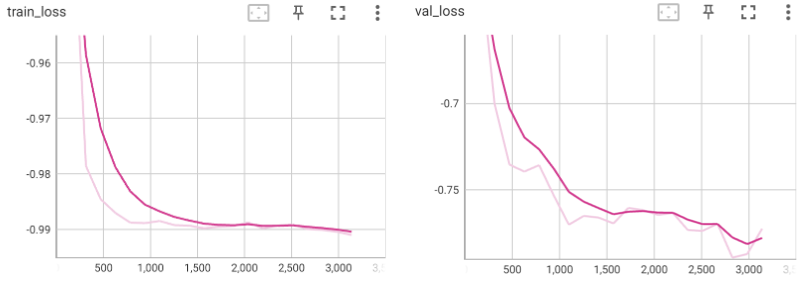

Модель обучилась, функция потерь уменьшается и выходит на почти константное значение и на обучении, и на валидации. При этом значения функции потерь на обучении и на валидации отличаются не сильно, имеют одинаковый порядок. В конце видно еще одно небольшое снижение функции потерь, можно немного дотренировать модель, однако вряд ли это сильно поменяет ее качество (улучшение не будет сильно значительным).  

#### Авторегрессионная модель



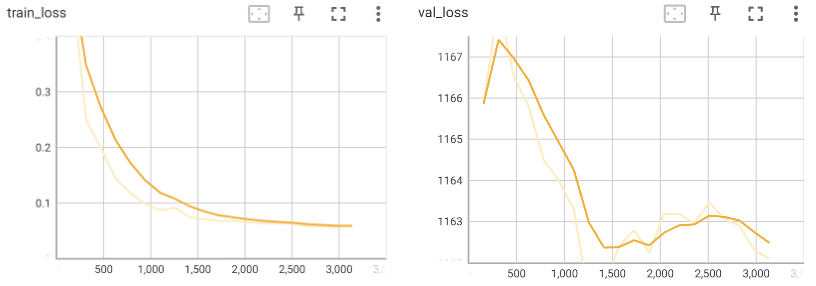

Графики функции потерь на обучении и валидации авторегрессионной модели тоже отражают ее снижение, однако значения на валидации на несколько порядков больше. Это говорит о том, что модель не обучилась. Но это не значит, что такой подход совсем не работает, дело может быть в архитектурах энкодера и декодера, оптимизаторе и т. д. Данная модель требует более тщательной подборки гиперпараметров.

#### Триплет-модель


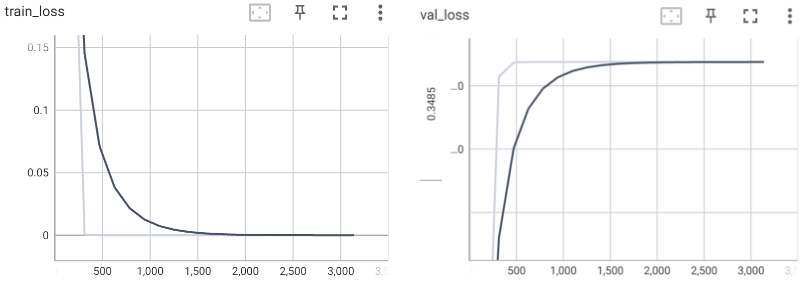

Как видно из графиков, модель переобучилась. Она также требует более тщательного подбора гиперпараметров.

#### Сиамская модель


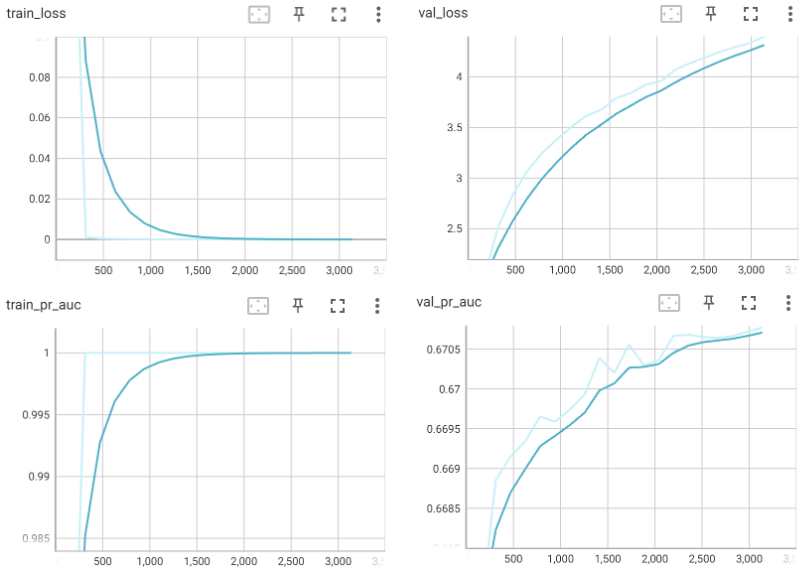


Аналогично триплет-модели переобучилась и сиамская модель. Это заметно не только по функции потерь, но и по PR AUC. Несмотря на то, что PR AUC растет и при обучении, и при валидации, на обучающей выборке он достигает единицы, в то время как на валидационной не может подняться до 0,7.